In [1]:
import numpy as np
import glob
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.core.debugger import Tracer

fnt = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
#InteractiveShell.ast_node_interactivity = "all"
print(os.getcwd())

C:\Users\Erik\Dropbox\School\Self Driving Car\CarND-Advanced-Lane-Lines


error: corners not found in camera_cal\calibration1.jpg - image not used
error: corners not found in camera_cal\calibration4.jpg - image not used
error: corners not found in camera_cal\calibration5.jpg - image not used


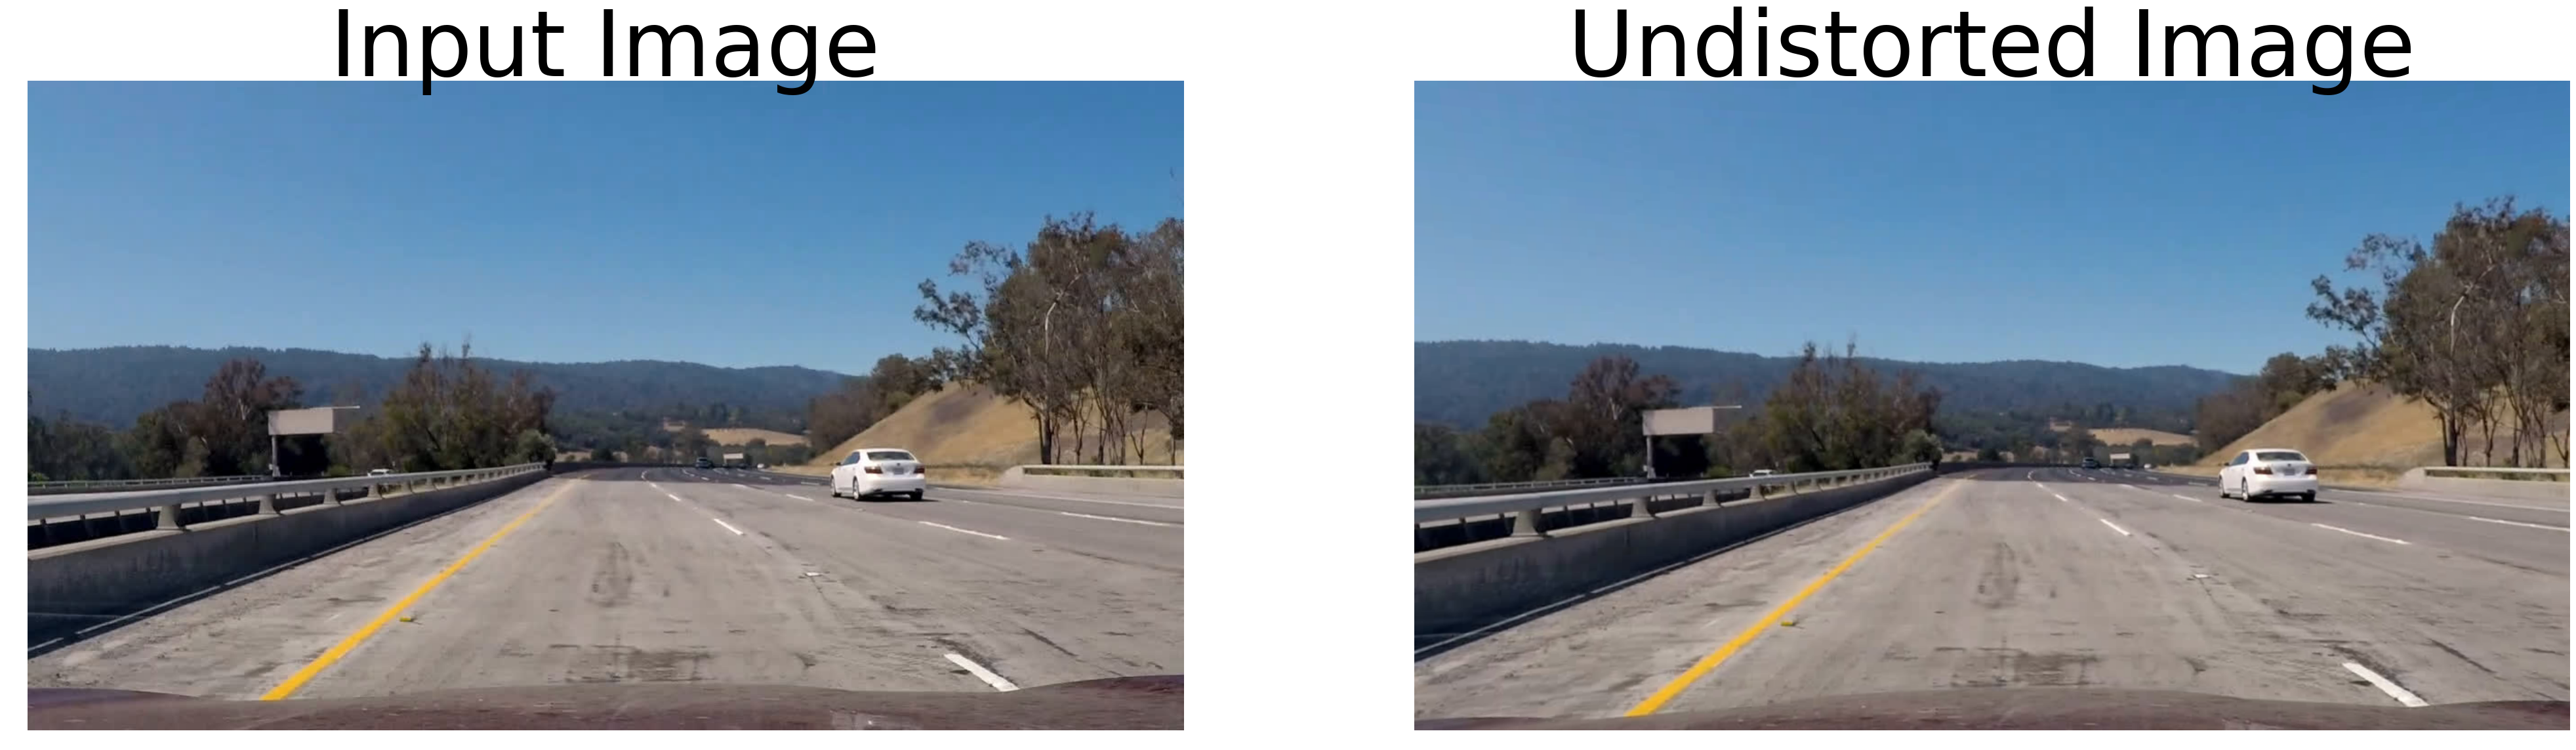

In [2]:
# Camera Calibration

images = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Read in an image
for fname in images:

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    else:
        print('error: corners not found in ' + fname + ' - image not used')
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

#test image
img = cv2.imread('test_images/frame.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50,50))
ax1.set_title("Input Image", fontsize=fnt)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.axis("off");
ax2.set_title("Undistorted Image", fontsize=fnt)
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.axis("off");

plt.show()


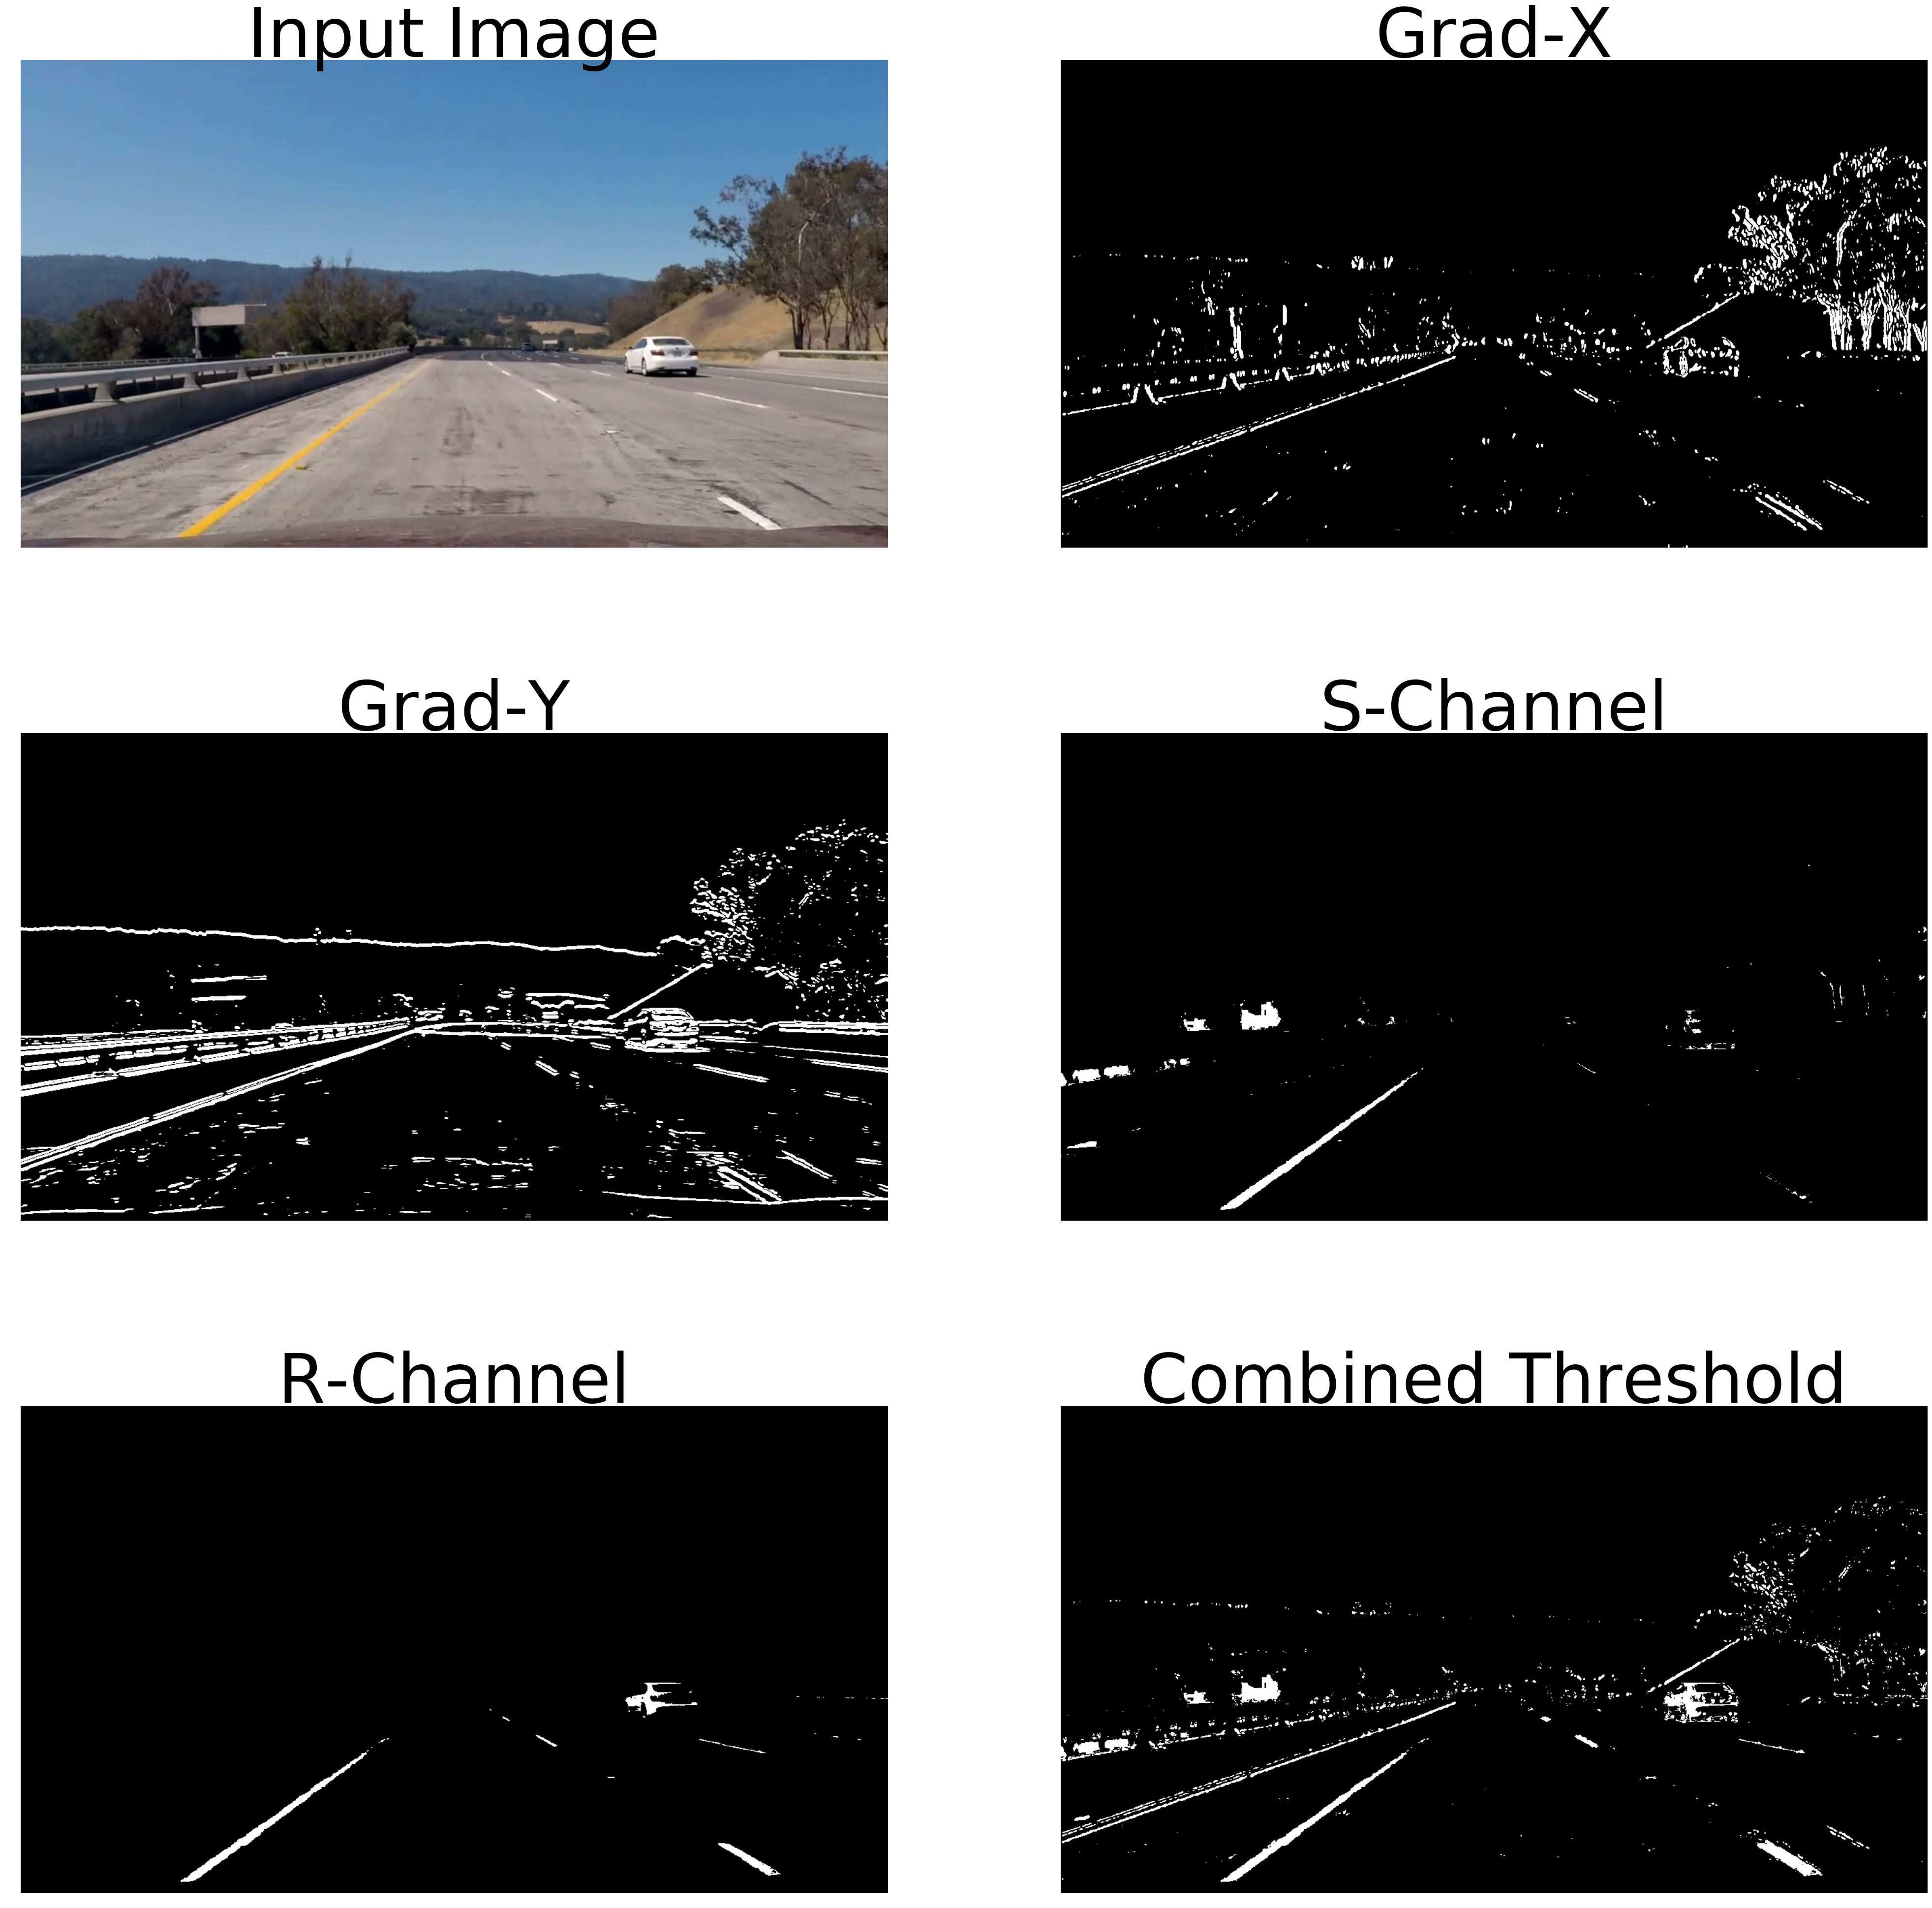

In [3]:
#Image Processing Functions

def threshold(image, thresh_min, thresh_max):
    # convert image to binary with given min and max threshold
    binary = np.zeros_like(image)
    binary[(image >= thresh_min) & (image <= thresh_max)] = 1
    return binary

def s_chan(img, thresh_min=170, thresh_max=250):
    # Convert image to HLS colour space and return the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    output = threshold(s_channel, thresh_min, thresh_max)
    return output

def r_chan(img, thresh_min=170, thresh_max=250):
    # return the R channel
    r_channel = img[:,:,2]
    output = threshold(r_channel, thresh_min, thresh_max)
    return output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output = threshold(scaled_sobel, thresh_min, thresh_max)
    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output = threshold(gradmag, thresh_min, thresh_max)
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output = threshold(absgraddir, thresh_min, thresh_max)
    # Return the binary image
    return binary_output

def combined_sobel(image):
    # Choose a Sobel kernel size (ksize)
    # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=200)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=200)
    s_channel = s_chan(image, thresh_min=170, thresh_max=255)
    r_channel = r_chan(image, thresh_min=220, thresh_max=255)
    #mag_binary = mag_thresh(image, sobel_kernel=9, thresh_min=80, thresh_max=255)
    #dir_binary = dir_threshold(image, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)

    combined = np.zeros_like(gradx)
    combined[((s_channel == 1) | (r_channel == 1)) | ((gradx == 1) & (grady == 1))] = 1
    
    return combined

#test image

gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=200)
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=200)
s_channel = s_chan(undistorted, thresh_min=150, thresh_max=255)
r_channel = r_chan(undistorted, thresh_min=220, thresh_max=255)
#mag_binary = mag_thresh(undistorted, sobel_kernel=9, thresh_min=80, thresh_max=255)
#dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)
combined = combined_sobel(undistorted)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6))= plt.subplots(3, 2, figsize=(50,50))

ax1.set_title("Input Image", fontsize=fnt)
ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax1.axis("off");

ax2.set_title("Grad-X", fontsize=fnt)
ax2.imshow(gradx, cmap='gray')
ax2.axis("off");

ax3.set_title("Grad-Y", fontsize=fnt)
ax3.imshow(grady, cmap='gray')
ax3.axis("off");

ax4.set_title("S-Channel", fontsize=fnt)
ax4.imshow(s_channel, cmap='gray')
ax4.axis("off");

ax5.set_title("R-Channel", fontsize=fnt)
ax5.imshow(r_channel, cmap='gray')
ax5.axis("off");

#ax6.set_title("mag_binary", fontsize=fnt)
#ax6.imshow(mag_binary, cmap='gray')
#ax6.axis("off");

#ax7.set_title("dir_binary", fontsize=fnt)
#ax7.imshow(dir_binary, cmap='gray')
#ax7.axis("off");

ax6.set_title("Combined Threshold", fontsize=fnt)
ax6.imshow(combined, cmap='gray')
ax6.axis("off");


plt.show()

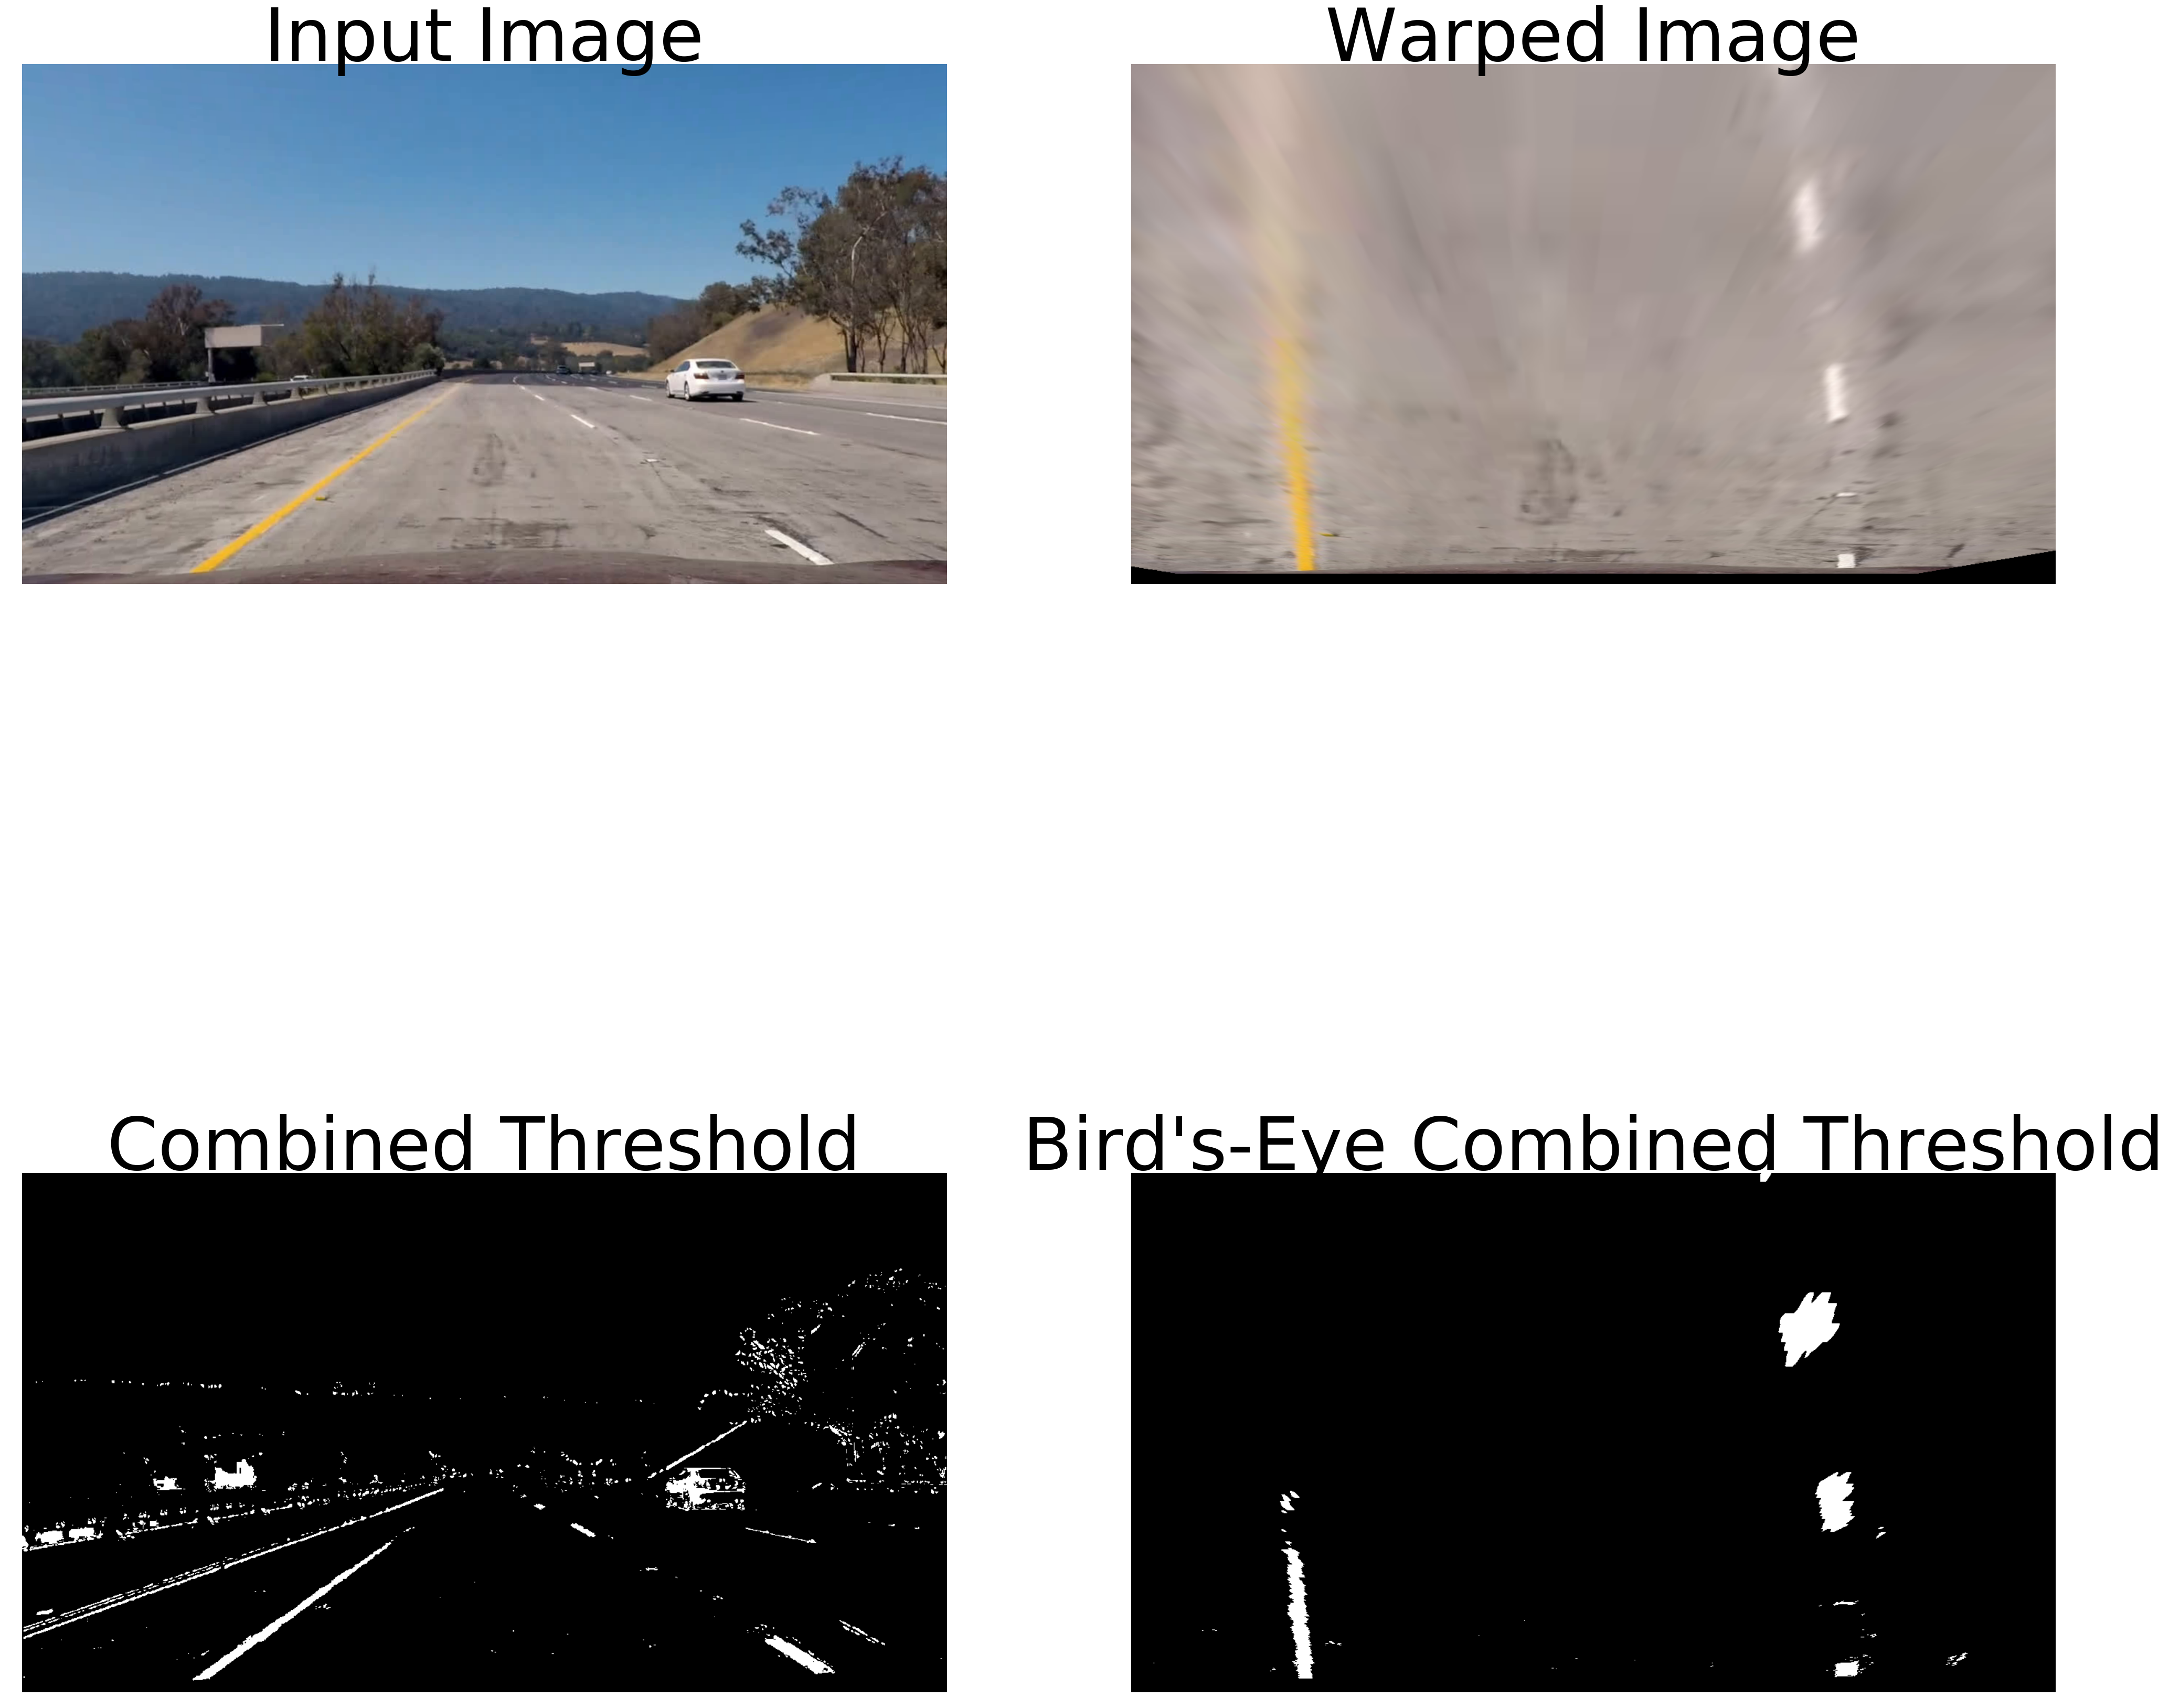

In [4]:
def warp(img):
    #source = [(600, 450), (680, 450), (1045, 680), (260, 680)]
    #dest = [(260, 0), (1045, 0), (1045, 680), (260, 680)]
    source = [(200, 700), (600, 450), (700, 450), (1080, 700)]    
    dest = [(200, 700), (200, 0), (950, 0), (950, 700)]
    
    img_size = (img.shape[1], img.shape[0]) # Grab the image shape
    src = np.float32(source)
    dst = np.float32(dest)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = np.linalg.inv(M)
    
    return warped, Minv

warped_undist, _ = warp(undistorted)
warped_comb, _ = warp(combined)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(50,50))
ax1.set_title("Input Image", fontsize=fnt)
ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax1.axis("off");

ax2.set_title("Warped Image", fontsize=fnt)
ax2.imshow(cv2.cvtColor(warped_undist, cv2.COLOR_BGR2RGB))
ax2.axis("off");

ax3.set_title("Combined Threshold", fontsize=fnt)
ax3.imshow(combined, cmap='gray')
ax3.axis("off");

ax4.set_title("Bird's-Eye Combined Threshold", fontsize=fnt)
ax4.imshow(warped_comb, cmap='gray')
ax4.axis("off");

plt.show()

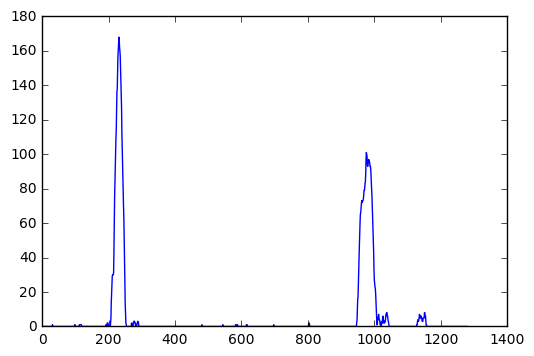

In [5]:
histogram = np.sum(warped_comb[int(warped_comb.shape[0]/2):,:], axis=0)
plt.plot(histogram);

In [6]:
def find_lane_lines(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)        

    return left_fit, leftx, lefty, right_fit, rightx, righty

In [7]:
def quick_find_lines(binary_warped):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, leftx, lefty, right_fit, rightx, righty

In [8]:
def curve_pos(leftx, lefty, rightx, righty):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)
    y_max = np.max(ploty)
    
    img_width = 1280*xm_per_pix
    img_height = 720*ym_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = round(((1 + (2*left_fit_cr[0]*img_height + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]), 1)
    right_curverad = round(((1 + (2*right_fit_cr[0]*img_height + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]), 1)
    
    left_bot = left_fit_cr[0] * img_height ** 2 + left_fit_cr[1] * img_height + left_fit_cr[2]
    right_bot = right_fit_cr[0] * img_height ** 2 + right_fit_cr[1] * img_height + right_fit_cr[2]
    
    lane_center = (left_bot+right_bot)/2
    car_pos = round(lane_center - img_width / 2.0, 2)
    
    return left_curverad, right_curverad, car_pos

In [9]:
def draw_lines(img, warped, Minv, left_fitx, right_fitx):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fitx[0]*ploty**2 + left_fitx[1]*ploty + left_fitx[2]
    right_fitx = right_fitx[0]*ploty**2 + right_fitx[1]*ploty + right_fitx[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    output = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return output

In [10]:
def pipeline(img):
    
  
    #preprocess image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx) 
    grad = combined_sobel(undistorted)
    warped, Minv = warp(grad)
    
    #find lines
    left_fit, leftx, lefty, right_fit, rightx, righty = find_lane_lines(warped)
    
    #calculate lane curvature and position
    left_curverad, right_curverad, car_pos = curve_pos(leftx, lefty, rightx, righty)
    
    #draw lines onto new image, print curvature, and position onto frame
    result = draw_lines(img, warped, Minv, left_fit, right_fit)
      
    cv2.putText(result,
                text = 'Left Curvature=' + str(left_curverad) + 'm, Right Curvature=' + str(right_curverad),
                org = (250,100),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1,
                color = (0,0,0),
                thickness = 3)
    
    cv2.putText(result,
                text = 'Position = ' + str(car_pos) + 'm',
                org = (350,650),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 2,
                color = (0,0,0),
                thickness = 3)
    
    #return new image and new line states
    return result

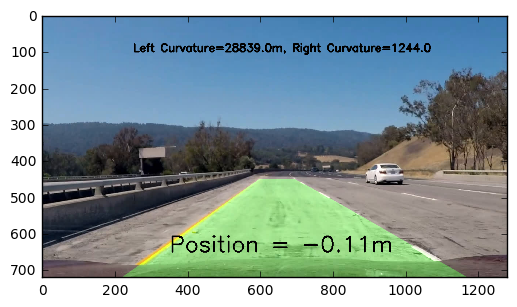

In [11]:
#testing pipeline
img = cv2.imread('test_images/frame.jpg')

result = pipeline(img)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
project_output = 'output_images/project.mp4'
clip1 = VideoFileClip('project_video.mp4', audio=False)
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#clip1.save_frame("test_images/frame.jpg", t=23)
#project_clip.preview()
%time project_clip.write_videofile(project_output, audio=False)

In [ ]:
project_output = 'output_images/challenge.mp4'
clip1 = VideoFileClip('challenge_video.mp4', audio=False)
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge.mp4
[MoviePy] Writing video output_images/challenge.mp4


 12%|████▉                                    | 59/485 [00:08<01:01,  6.98it/s]

KeyboardInterrupt: 

In [ ]:
project_output = 'output_images/harder_challenge.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4', audio=False)
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge.mp4
[MoviePy] Writing video output_images/harder_challenge.mp4



  2%|▉                                       | 27/1200 [00:04<03:01,  6.47it/s]